In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, RidgeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, StackingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer
from sklearn.base import RegressorMixin, ClassifierMixin, BaseEstimator
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor


### Data Collection

In [ ]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module6/exercise/module6_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module6/exercise/module6_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module6_exercise_train.csv')
download_file(test_data_url, 'module6_exercise_test.csv')

In [ ]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
data_test = pd.read_csv('module6_exercise_test.csv', index_col='index')
df = data_train.copy()

### Data Analysis

In [ ]:
data_train

In [ ]:
data_test

In [ ]:
data_train.describe()

In [ ]:
data_train.isnull().sum()

In [ ]:
data_test.isnull().sum()

In [ ]:
# Plot the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data_train['end_of_day_return'], bins=50, kde=True)
plt.title('Distribution of End of Day Return')
plt.xlabel('End of Day Return')
plt.ylabel('Frequency')
plt.show()

In [ ]:
corrs = data_train.corr(numeric_only=True)["end_of_day_return"].sort_values()
corrs.plot(kind="barh", figsize=(8,8))


In [ ]:
data_train

In [ ]:
sns.heatmap(data_train.corr(), cmap="coolwarm", center=0)

In [ ]:
df["target_sign"] = np.sign(df["end_of_day_return"])
df.groupby("target_sign").mean().T.plot(figsize=(10,5))
plt.title("Moyenne des mouvements intraday selon le signe du retour final")


### Model Building and Evaluate

In [ ]:
from sklearn.model_selection import train_test_split

y = data_train.pop('end_of_day_return')
X = data_train.copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X

In [ ]:
def weighted_accuracy(y_true, y_pred):
    weights = np.abs(y_true)
    
    # Compute the sign of true and predicted values
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    
    # Correct predictions where the sign of the true and predicted values match
    correct_predictions = sign_true == sign_pred
    
    # Compute the weighted accuracy
    weighted_acc = np.sum(weights * correct_predictions) / np.sum(weights)
    
    return weighted_acc 

In [ ]:
# Function to plot the evaluation results
def plot_results(mse_train, mse_test, w_acc_train, w_acc_test):
    plt.figure(figsize=(12, 6))

    # MSE plot
    plt.subplot(1, 2, 1)
    plt.plot(mse_train, label="Train MSE", marker='o')
    plt.plot(mse_test, label="Test MSE", marker='o')
    plt.fill_between(range(len(mse_train)), np.min(mse_train), np.max(mse_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(mse_test)), np.min(mse_test), np.max(mse_test), color='orange', alpha=0.1)
    plt.title("MSE over Folds")
    plt.xlabel("Fold")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    # weighted_accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(w_acc_train, label="Train weighted_accuracy", marker='o')
    plt.plot(w_acc_test, label="Test weighted_accuracy", marker='o')
    plt.fill_between(range(len(w_acc_train)), np.min(w_acc_train), np.max(w_acc_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(w_acc_test)), np.min(w_acc_test), np.max(w_acc_test), color='orange', alpha=0.1)
    plt.title("weighted_accuracy over Folds")
    plt.xlabel("Fold")
    plt.ylabel("weighted_accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_multi_model_results(results):
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))
    
    # Colors for train and test
    train_color = 'skyblue'
    test_color = 'lightgreen'
    
    # Plot MSE
    ax1.set_title('Mean Squared Error (MSE) Comparison', fontsize=16)
    ax1.set_ylabel('MSE', fontsize=12)
    ax1.set_xlabel('Models', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot weighted_accuracy
    ax2.set_title('weighted_accuracy Comparison', fontsize=16)
    ax2.set_ylabel('weighted_accuracy', fontsize=12)
    ax2.set_xlabel('Models', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    x = np.arange(len(results))
    width = 0.35
    
    for i, (model_name, scores) in enumerate(results.items()):
        # MSE
        mse_train = scores['mse_train']
        mse_test = scores['mse_test']
        
        ax1.bar(x[i] - width/2, np.mean(mse_train), width, label='Train' if i == 0 else "", 
                color=train_color, alpha=0.7)
        ax1.bar(x[i] + width/2, np.mean(mse_test), width, label='Test' if i == 0 else "", 
                color=test_color, alpha=0.7)
        
        ax1.errorbar(x[i] - width/2, np.mean(mse_train), 
                     yerr=[[np.mean(mse_train)-np.min(mse_train)], [np.max(mse_train)-np.mean(mse_train)]], 
                     fmt='none', ecolor='black', capsize=5)
        ax1.errorbar(x[i] + width/2, np.mean(mse_test), 
                     yerr=[[np.mean(mse_test)-np.min(mse_test)], [np.max(mse_test)-np.mean(mse_test)]], 
                     fmt='none', ecolor='black', capsize=5)
        
        # weighted_accuracy
        w_acc_train = scores['w_acc_train']
        w_acc_test = scores['w_acc_test']
        
        ax2.bar(x[i] - width/2, np.mean(w_acc_train), width, label='Train' if i == 0 else "", 
                color=train_color, alpha=0.7)
        ax2.bar(x[i] + width/2, np.mean(w_acc_test), width, label='Test' if i == 0 else "", 
                color=test_color, alpha=0.7)
        
        ax2.errorbar(x[i] - width/2, np.mean(w_acc_train), 
                     yerr=[[np.mean(w_acc_train)-np.min(w_acc_train)], [np.max(w_acc_train)-np.mean(w_acc_train)]], 
                     fmt='none', ecolor='black', capsize=5)
        ax2.errorbar(x[i] + width/2, np.mean(w_acc_test), 
                     yerr=[[np.mean(w_acc_test)-np.min(w_acc_test)], [np.max(w_acc_test)-np.mean(w_acc_test)]], 
                     fmt='none', ecolor='black', capsize=5)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(results.keys(), rotation=45, ha='right')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results.keys(), rotation=45, ha='right')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

#### Simple Baseline

In [ ]:
# Function to handle train-test evaluation in a fold
def train_and_evaluate(X_train, X_test, y_train, y_test, model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on train set
    y_pred_train = model.predict(X_train)
    # Make predictions on train set
    y_pred_test = model.predict(X_test)
    
    # Compute MSE for train and test
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # Compute weighted_accuracy
    
    w_acc_train = weighted_accuracy(y_train, y_pred_train)
    w_acc_test = weighted_accuracy(y_test, y_pred_test)
    
    return mse_train, mse_test, w_acc_train, w_acc_test


def run_multi_model_cv(X, y, models, n_splits=5):
    fold = KFold(n_splits=n_splits)
    results = {name: {'mse_train': [], 'mse_test': [], 'w_acc_train': [], 'w_acc_test': []} 
               for name in models.keys()}
    
    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        for name, model in models.items():
            mse_train, mse_test, w_acc_train, w_acc_test = train_and_evaluate(
                X_train, X_test, y_train, y_test, model
            )
            results[name]['mse_train'].append(mse_train)
            results[name]['mse_test'].append(mse_test)
            results[name]['w_acc_train'].append(w_acc_train)
            results[name]['w_acc_test'].append(w_acc_test)
        # Find the model with the best mean w_acc test score
    best_mean_w_acc = -1
    best_model = None
    best_min_w_acc = None
    best_max_w_acc = None
    
    for name, result in results.items():
        w_acc_test_scores = result['w_acc_test']
        mean_w_acc_test = sum(w_acc_test_scores) / len(w_acc_test_scores)  # Calculate mean w_acc score
        min_w_acc_test = min(w_acc_test_scores)  # Minimum w_acc score
        max_w_acc_test = max(w_acc_test_scores)  # Maximum w_acc score
        
        if mean_w_acc_test > best_mean_w_acc:
            best_mean_w_acc = mean_w_acc_test
            best_min_w_acc = min_w_acc_test
            best_max_w_acc = max_w_acc_test
            best_model = name
    
    # Print the best mean w_acc test score, min, max, and the associated model
    print(f"Best mean w_acc test score: {best_mean_w_acc:.4f} by model: {best_model}")
    print(f"Min w_acc test score: {best_min_w_acc:.4f}, Max w_acc test score: {best_max_w_acc:.4f}")
    return results


In [ ]:
# Step 1: Run cross-validation
results = run_multi_model_cv(X, y, {"RandomForestRegressor": RandomForestRegressor(n_jobs=-1, random_state=42)})

In [ ]:
# Step 2: Plot the results
plot_results(results["RandomForestRegressor"]["mse_train"],
             results["RandomForestRegressor"]["mse_test"],
             results["RandomForestRegressor"]["w_acc_train"],
             results["RandomForestRegressor"]["w_acc_test"])

In [ ]:
models = {
    'Ridge': Ridge(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Lasso': Lasso(random_state=42, max_iter=5000),
    'KNN Regressor': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42, verbose=-1)
    }

In [ ]:
# Run cross-validation for regression models
results = run_multi_model_cv(X, y, models)

In [ ]:
# Plot MSE results for regression models
plot_multi_model_results(results)

#### Manage properly the objective weighted_accuracy
should we create different classes? custom loss?

Create Compare and Optimize different models

### First try : GridSearch

#### Grid search on ridge and lasso

In [ ]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
y = data_train.pop('end_of_day_return')
X = data_train.copy()#.drop(columns=['electricity_demand'], axis=1)
X

In [ ]:
from sklearn.model_selection import GridSearchCV



# Define parameter combinations to test
# param_grid = {
#     'alpha': [0.01, 0.1, 1, 10, 100],  # force de régularisation
#     'solver': ['svd', 'cholesky', 'lsqr', 'saga']  # méthode de résolution
# }
param_grid = {
    'alpha': np.logspace(-3, 0, 5),  # 0.001 → 1
    'max_iter': [1000, 5000, 10000]
}


# Create model and grid search
# ridge = Ridge()
lasso = Lasso()
grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=5,                  # validation croisée à 5 plis
    scoring='neg_mean_squared_error',          # métrique : coefficient de détermination
    random_state=42,
    n_jobs=-1              # parallélisation
)

# Fit on your data
grid_search.fit(X, y)

# Best parameters found
print("Best params:", grid_search.best_params_)
print("Best neg MSE (CV):", grid_search.best_score_)
print("True MSE (CV):", -grid_search.best_score_)  # remettre le signe positif


Ridge  
Best params: {'alpha': 10, 'solver': 'saga'}  
Best neg MSE (CV): -0.45950629400842075
True MSE (CV): 0.45950629400842075
  
Lasso  
Best params: {'alpha': 0.005623413251903491, 'max_iter': 1000}  
Best neg MSE (CV): -0.4583305618636261  
True MSE (CV): 0.4583305618636261

#### Result comparison

In [ ]:

models = {
    'Ridge': Ridge(alpha=10, solver='saga', random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Lasso': Lasso(alpha=0.005623413251903491, max_iter=1000, random_state=42),
    'KNN Regressor': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42, verbose=-1)
    }

In [ ]:
# Run cross-validation for regression models
results = run_multi_model_cv(X, y, models)

In [ ]:
plot_multi_model_results(results)

#### Résultat original

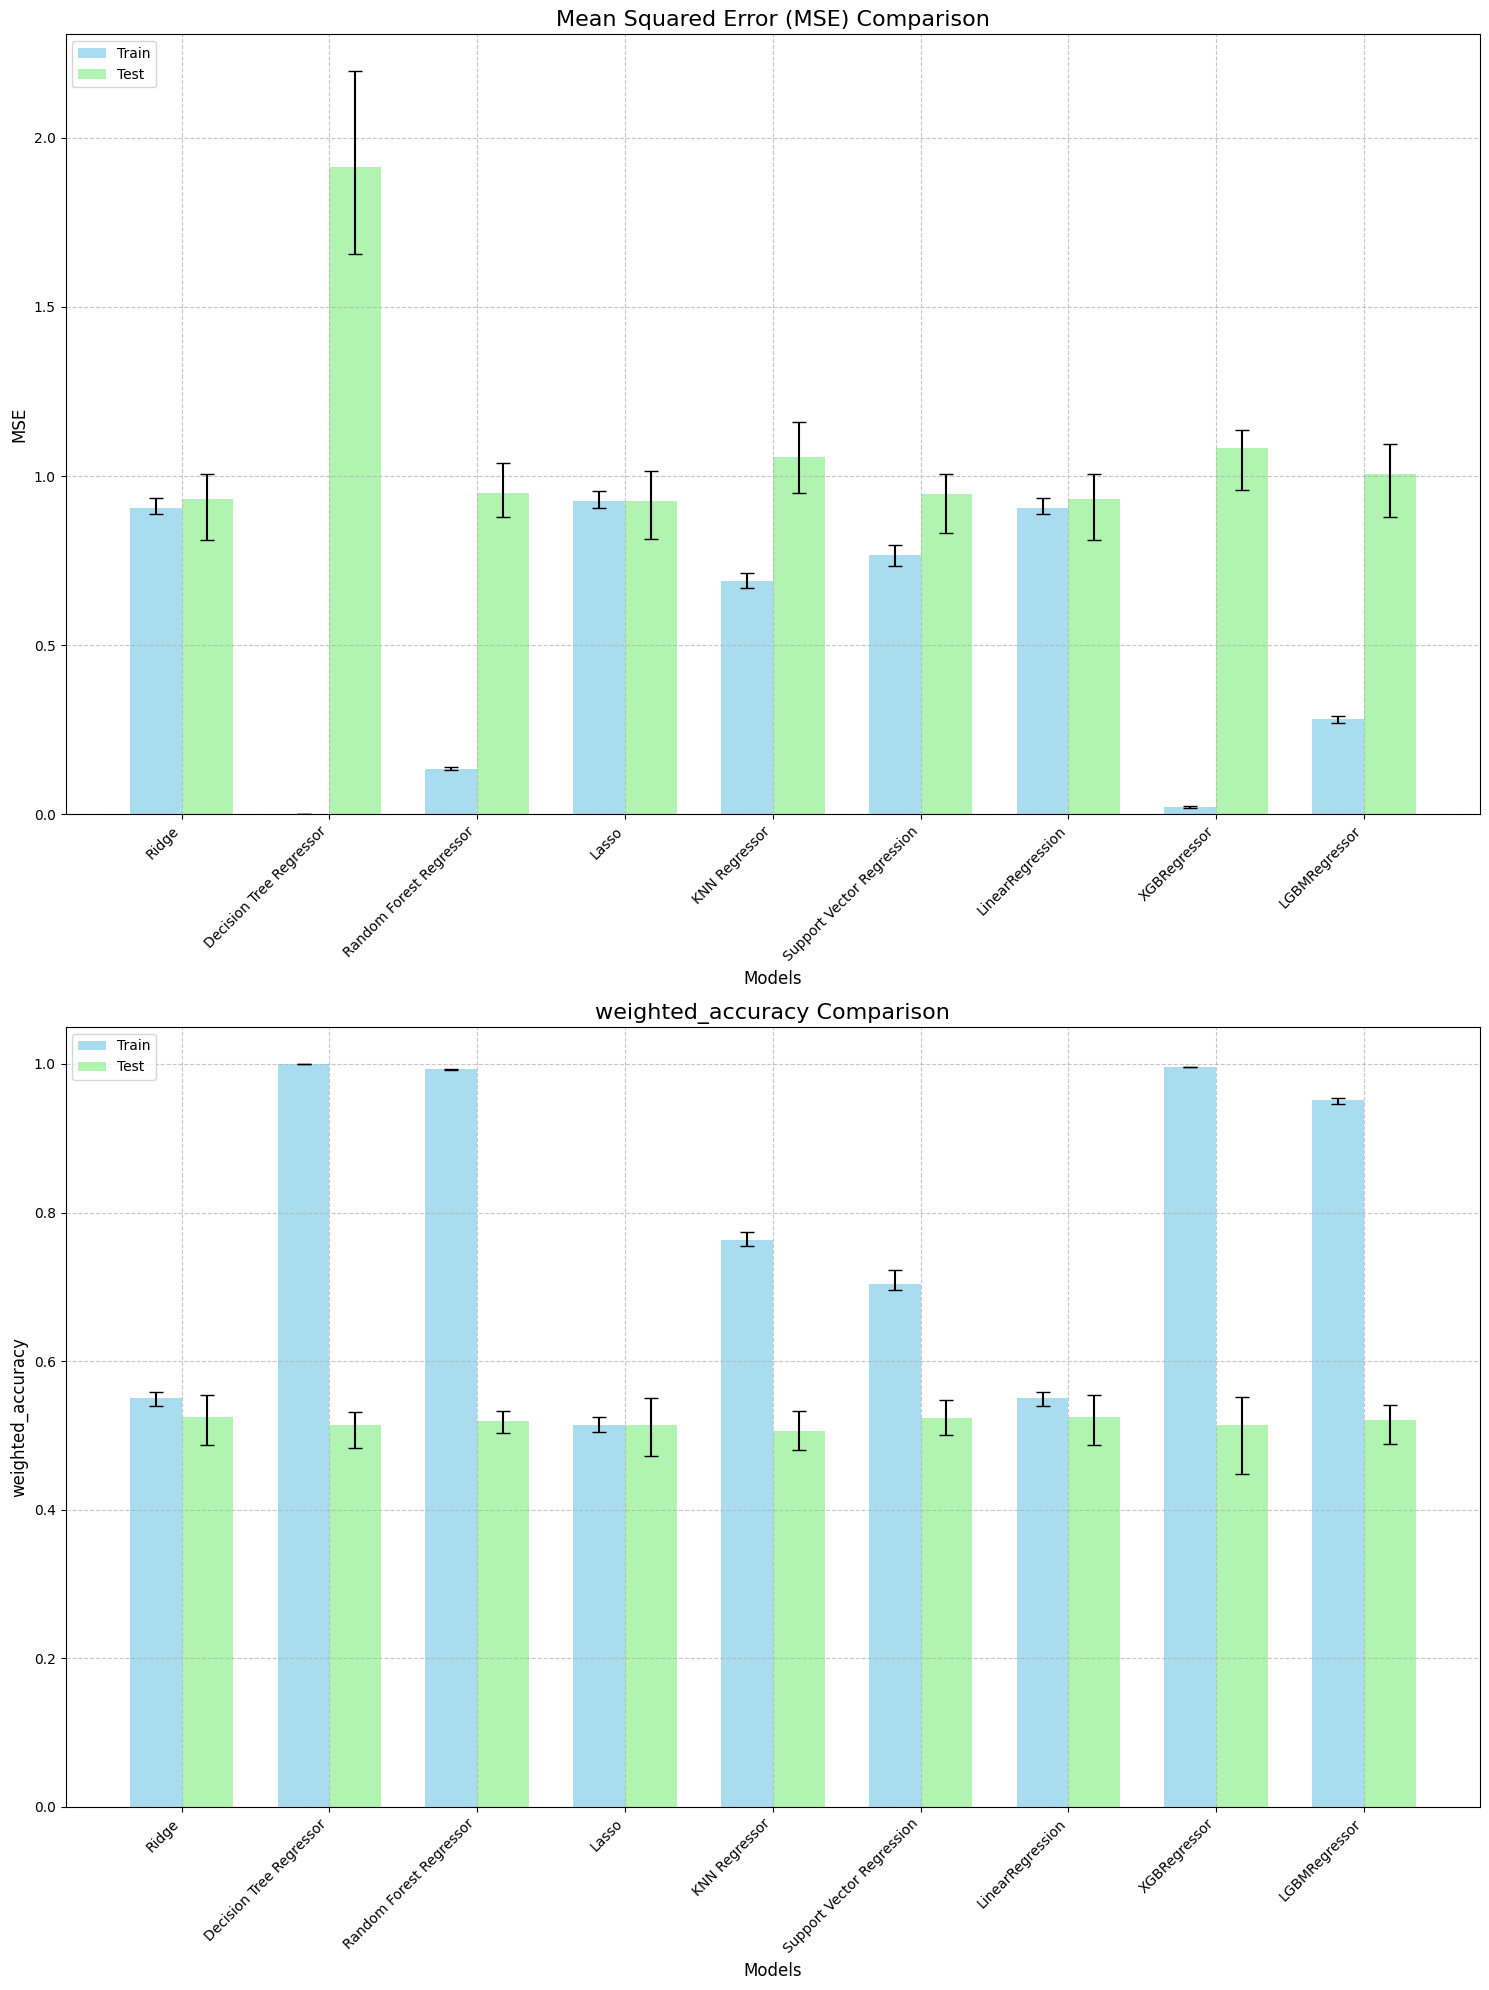

### Random search 

In [ ]:
models = {
    'Ridge': Ridge(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Lasso': Lasso(random_state=42, max_iter=5000),
    'KNN Regressor': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42, verbose=-1)
    }

In [ ]:
param_grids = {
    'Ridge': {
        'alpha': [0.01, 0.1, 1, 10, 100],  # force de régularisation
        'solver': ['svd', 'cholesky', 'lsqr', 'saga']  # méthode de résolution
    },
    'Decision Tree Regressor': {
        'max_depth': [3, 5, 7, 10, None],          # Limite la complexité
        'min_samples_split': [2, 5, 10, 20],       # Plus grand = plus de régularisation
        'min_samples_leaf': [1, 2, 5, 10],         # Empêche des feuilles isolées
    },
    'Random Forest Regressor': {
        
    },
    'Lasso': {
        'alpha': np.logspace(-3, 0, 5),  # 0.001 → 1
        'max_iter': [1000, 5000, 10000]
    },
    'KNN Regressor': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': {
        'max_depth': [3, 5, 7],                # Réduit la taille des arbres
        'learning_rate': [0.01, 0.05, 0.1],    # Plus petit = apprentissage plus lent mais plus stable
        'n_estimators': [200, 500, 800],       # Lié au learning_rate
        'subsample': [0.6, 0.8, 1.0],          # Randomisation partielle → régularise
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_lambda': [0, 0.5, 1],             # L2 regularization
        'reg_alpha': [0, 0.5, 1]               # L1 regularization
    },
    'LGBMRegressor': {
        'num_leaves': [15, 31, 63],         # Trop haut = overfit
        'max_depth': [3, 5, 7, -1],         # -1 = pas de limite
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [200, 500, 800],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'lambda_l1': [0, 0.5, 1],
        'lambda_l2': [0, 0.5, 1],
        'min_data_in_leaf': [10, 30, 100],  # augmente si overfit
    }
    }


param_grids = {
    'Ridge': {
        'alpha': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 0.1, 0.5, 1, 5, 10, 50, 100],
        'solver': ['auto', 'svd', 'lsqr', 'sag', 'saga']
    },
    'Decision Tree Regressor': {
        'max_depth': [3, 5, 7, 10, None],          # Limite la complexité
        'min_samples_split': [2, 5, 10, 20],       # Plus grand = plus de régularisation
        'min_samples_leaf': [1, 2, 5, 10],         # Empêche des feuilles isolées
    },
    'Random Forest Regressor': {
        'n_estimators': [300, 600, 1000],
        'max_depth': [5, 8, 12, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['sqrt', 0.3, 0.5, 1.0],
        'bootstrap': [True],
        'oob_score': [True],
        'n_jobs': [-1],
        'random_state': [42]
    },
    'Lasso': {
        'alpha': [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1.0],
        'max_iter': [1000, 5000, 10000],
        'selection': ['cyclic', 'random']
    },
    'KNN Regressor': {
        'n_neighbors': [3, 5, 11, 21, 31, 51],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'leaf_size': [15, 30, 60]
    },
    'Support Vector Regression': [
        {
            'kernel': ['linear'],
            'C': [0.1, 0.5, 1, 5, 10, 50],
            'epsilon': [0.01, 0.05, 0.1, 0.2]
        },
        {
            'kernel': ['rbf'],
            'C': [0.5, 1, 5, 10, 50],
            'epsilon': [0.01, 0.05, 0.1, 0.2],
            'gamma': ['scale', 'auto']
        }
    ],
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [False]
    },
    'XGBRegressor': {
        'max_depth': [3, 5, 7],                # Réduit la taille des arbres
        'learning_rate': [0.01, 0.05, 0.1],    # Plus petit = apprentissage plus lent mais plus stable
        'n_estimators': [200, 500, 800],       # Lié au learning_rate
        'subsample': [0.6, 0.8, 1.0],          # Randomisation partielle → régularise
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_lambda': [0, 0.5, 1],             # L2 regularization
        'reg_alpha': [0, 0.5, 1]               # L1 regularization
    },
    'LGBMRegressor': {
        'num_leaves': [15, 31, 63],         # Trop haut = overfit
        'max_depth': [3, 5, 7, -1],         # -1 = pas de limite
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [200, 500, 800],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'lambda_l1': [0, 0.5, 1],
        'lambda_l2': [0, 0.5, 1],
        'min_data_in_leaf': [10, 30, 100],  # augmente si overfit
    }
}



In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def run_multi_model_grid_search(X, y, models, param_grids, n_splits=4, n_iter=30, random_state=42):
    best_params = {}
    for i, (name, model) in enumerate(models.items()):
        print(i, 'RandomizedSearchCV pour : ', name)
        search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=n_iter,
        cv=n_splits,                  # validation croisée à 5 plis
        scoring='neg_mean_squared_error',          # métrique : coefficient de détermination
        n_jobs=-1,              # parallélisation
        random_state=random_state,
        verbose=1             
        )
        search.fit(X, y)
        print('Meilleurs paramètres : ', search.best_params_)
        best_model = search.best_estimator_
        models[name] = best_model
        best_params[name] = search.best_params_
    return models, best_params



In [ ]:
models_grid_search, best_params = run_multi_model_grid_search(X, y, models, param_grids)

In [ ]:
models_grid_search, best_params = models_grid_search

In [ ]:
models_grid_search

In [ ]:
for i, (name, model) in enumerate(models_grid_search.items()):
    print(i, name, model)

0 Ridge Ridge(alpha=100, solver='svd')  
1 Decision Tree Regressor DecisionTreeRegressor(max_depth=3, min_samples_leaf=10)  
2 Random Forest Regressor RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_split=10,
                      n_estimators=600, n_jobs=-1, oob_score=True,
                      random_state=42)  
3 Lasso Lasso(selection='random')  
4 KNN Regressor KNeighborsRegressor(n_neighbors=51, p=1, weights='distance')  
5 Support Vector Regression SVR(C=0.1, epsilon=0.2, kernel='linear')  
6 LinearRegression LinearRegression()  
7 XGBRegressor XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)  
8 LGBMRegressor LGBMRegressor(lambda_l1=1, lambda_l2=0, learning_rate=0.01, max_depth=3,
              min_data_in_leaf=10, n_estimators=200, verbose=-1)  

In [ ]:
# Run cross-validation for regression models
results_grid_search = run_multi_model_cv(X, y, models_grid_search)

In [ ]:
plot_multi_model_results(results_grid_search)

#### Random Search : weighted accuracy - Coarse

In [ ]:
models = {
    'Ridge': Ridge(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Lasso': Lasso(random_state=42, max_iter=5000),
    'KNN Regressor': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42, verbose=-1)
    }

In [ ]:
fast_param_grids = {
    'Ridge': {
        'alpha': [1e-2, 1e-1, 1, 10, 100],
        'solver': ['auto', 'lsqr']
    },
    'Decision Tree Regressor': {
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5]
    },
    'Random Forest Regressor': {
        'n_estimators': [300, 600],
        'max_depth': [8, None],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5],
        'max_features': ['sqrt', 0.5],
        'bootstrap': [True]
    },
    'Lasso': {
        'alpha': [1e-3, 1e-2, 1e-1, 0.3, 1.0],
        'max_iter': [5000],
        'selection': ['cyclic']
    },
    'KNN Regressor': {
        'n_neighbors': [5, 21, 51],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Support Vector Regression': [
        {   # linéaire
            'kernel': ['linear'],
            'C': [0.5, 5],
            'epsilon': [0.05, 0.1]
        },
        {   # RBF
            'kernel': ['rbf'],
            'C': [1, 10],
            'epsilon': [0.05, 0.1],
            'gamma': ['scale']
        }
    ],
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [False]
    },
    'XGBRegressor': {
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [300, 600],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'reg_lambda': [0, 1],
        'reg_alpha': [0, 1]
    },
    'LGBMRegressor': {
        'num_leaves': [31, 63],
        'max_depth': [5, -1],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [300, 600],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'lambda_l1': [0, 1],
        'lambda_l2': [0, 1],
        'min_data_in_leaf': [30, 100]
    }
}


In [ ]:
from scipy.stats import uniform, randint, loguniform

fast_search_space = {
    'Ridge': {
        'alpha': loguniform(1e-3, 1e2),  # plage continue entre 1e-3 et 100
        'solver': ['auto', 'lsqr']
    },
    'Decision Tree Regressor': {
        'max_depth': [None] + list(range(3, 21)),  # profondeur variable
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'Random Forest Regressor': {
        'n_estimators': randint(200, 800),
        'max_depth': [None] + list(range(5, 20)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': uniform(0.3, 0.7),  # valeurs continues entre 0.3 et 1.0
        'bootstrap': [True]
    },
    'Lasso': {
        'alpha': loguniform(1e-4, 1.0),
        'max_iter': [5000],
        'selection': ['cyclic']
    },
    'KNN Regressor': {
        'n_neighbors': randint(3, 60),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Support Vector Regression': [
        {   # linéaire
            'kernel': ['linear'],
            'C': loguniform(1e-1, 10),
            'epsilon': uniform(0.01, 0.2)
        },
        {   # RBF
            'kernel': ['rbf'],
            'C': loguniform(1e-1, 10),
            'epsilon': uniform(0.01, 0.2),
            'gamma': ['scale', 'auto']
        }
    ],
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [False]
    },
    'XGBRegressor': {
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(200, 800),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_lambda': uniform(0, 2),
        'reg_alpha': uniform(0, 2)
    },
    'LGBMRegressor': {
        'num_leaves': randint(20, 80),
        'max_depth': [-1] + list(range(4, 12)),
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(200, 800),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'lambda_l1': uniform(0, 2),
        'lambda_l2': uniform(0, 2),
        'min_data_in_leaf': randint(20, 150)
    }
}


In [ ]:
from sklearn.metrics import make_scorer

weighted_accuracy_scorer = make_scorer(weighted_accuracy, greater_is_better=True)
def run_multi_model_random_search(X, y, models, search_space, scorer=weighted_accuracy_scorer, n_splits=4, n_iter=30, random_state=42):
    best_params = {}
    for i, (name, model) in enumerate(models.items()):
        print(i, 'RandomizedSearchCV pour : ', name)
        search = RandomizedSearchCV(
        estimator=model,
        param_distributions=search_space[name],
        n_iter=n_iter,
        cv=n_splits,                  # validation croisée à 5 plis
        scoring=scorer,          # métrique : coefficient de détermination
        n_jobs=-1,              # parallélisation
        random_state=random_state,
        verbose=1             
        )
        search.fit(X, y)
        print('Meilleurs paramètres : ', search.best_params_)
        best_model = search.best_estimator_
        models[name] = best_model
        best_params[name] = search.best_params_
    return models, best_params

In [ ]:
models_random_search, best_params_random_search = run_multi_model_random_search(X, y, models, fast_search_space)

In [ ]:
from scipy.stats import uniform, randint, loguniform

fine_search_space = {
    'Ridge': {
        'alpha': loguniform(65, 80),  # plage continue entre 1e-3 et 100
        'solver': ['auto', 'lsqr']
    },
    'Decision Tree Regressor': {
        'max_depth': list(range(2, 6)),  # profondeur variable
        'min_samples_split': randint(1, 6),
        'min_samples_leaf': randint(1, 5)
    },
    'Random Forest Regressor': {
        'n_estimators': randint(200, 800),
        'max_depth': [None] + list(range(5, 20)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': uniform(0.3, 0.7),  # valeurs continues entre 0.3 et 1.0
        'bootstrap': [True]
    },
    'Lasso': {
        'alpha': loguniform(1e-4, 1.0),
        'max_iter': [5000],
        'selection': ['cyclic']
    },
    'KNN Regressor': {
        'n_neighbors': randint(3, 60),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Support Vector Regression': [
        {   # linéaire
            'kernel': ['linear'],
            'C': loguniform(1e-1, 10),
            'epsilon': uniform(0.01, 0.2)
        },
        {   # RBF
            'kernel': ['rbf'],
            'C': loguniform(1e-1, 10),
            'epsilon': uniform(0.01, 0.2),
            'gamma': ['scale', 'auto']
        }
    ],
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [False]
    },
    'XGBRegressor': {
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(200, 800),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_lambda': uniform(0, 2),
        'reg_alpha': uniform(0, 2)
    },
    'LGBMRegressor': {
        'num_leaves': randint(20, 80),
        'max_depth': [-1] + list(range(4, 12)),
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(200, 800),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'lambda_l1': uniform(0, 2),
        'lambda_l2': uniform(0, 2),
        'min_data_in_leaf': randint(20, 150)
    }
}


In [ ]:
fine_param_grids = {
    'Ridge': {
        'alpha': [7, 10, 50, 100],
        'solver': ['saga', 'lsqr']
    },
    'Decision Tree Regressor': {
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5]
    },
    'Random Forest Regressor': {
        'n_estimators': [300, 600],
        'max_depth': [8, None],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 5],
        'max_features': ['sqrt', 0.5],
        'bootstrap': [True]
    },
    'Lasso': {
        'alpha': [1e-3, 1e-2, 1e-1, 0.3, 1.0],
        'max_iter': [5000],
        'selection': ['cyclic']
    },
    'KNN Regressor': {
        'n_neighbors': [5, 21, 51],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'Support Vector Regression': [
        {   # linéaire
            'kernel': ['linear'],
            'C': [0.5, 5],
            'epsilon': [0.05, 0.1]
        },
        {   # RBF
            'kernel': ['rbf'],
            'C': [1, 10],
            'epsilon': [0.05, 0.1],
            'gamma': ['scale']
        }
    ],
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [False]
    },
    'XGBRegressor': {
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [300, 600],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'reg_lambda': [0, 1],
        'reg_alpha': [0, 1]
    },
    'LGBMRegressor': {
        'num_leaves': [31, 63],
        'max_depth': [5, -1],
        'learning_rate': [0.05, 0.1],
        'n_estimators': [300, 600],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'lambda_l1': [0, 1],
        'lambda_l2': [0, 1],
        'min_data_in_leaf': [30, 100]
    }
}


In [ ]:
# Run cross-validation for regression models
results_random_search = run_multi_model_cv(X, y, models_random_search)

In [ ]:
plot_multi_model_results(results_random_search)

#### RS - Fine search

In [ ]:
from scipy.stats import uniform, randint, loguniform

refined_search_space = {
    # Faible impact -> espace très serré
    "Ridge": {
        "alpha": loguniform(1e1, 2e2),   # ~10 à 200, centré autour de ~74
        "solver": ["auto", "lsqr"]
    },
    "Lasso": {
        "alpha": loguniform(3e-1, 1.5),  # ~0.3 à 1.5 autour de ~0.64
        "max_iter": [5000],
        "selection": ["cyclic"]
    },
    "LinearRegression": {
        "fit_intercept": [True],         # meilleur trouvé
        "positive": [False]
    },

    # Arbres simples -> resserré pour éviter surajustement
    "Decision Tree Regressor": {
        "max_depth": [3, 4, 5, 6, 7, 8],
        "min_samples_split": randint(2, 11),  # 2–10
        "min_samples_leaf": randint(1, 6)     # 1–5
    },

    # Random Forest -> moins de features, profondeur modérée
    "Random Forest Regressor": {
        "n_estimators": randint(500, 901),               # 500–900
        "max_depth": [8, 9, 10, 11, 12, 13, 14, 15, 16],
        "min_samples_split": randint(2, 8),              # 2–7
        "min_samples_leaf": randint(1, 4),               # 1–3
        "max_features": uniform(0.2, 0.35),              # 0.2–0.55 (meilleur ≈0.324)
        "bootstrap": [True]
    },

    # KNN -> voisinage grand avec distance Manhattan préférée
    "KNN Regressor": {
        "n_neighbors": randint(40, 71),    # 40–70 autour de 59
        "weights": ["uniform", "distance"],
        "p": [1]                            # ton best → L1
    },

    # SVR -> RBF uniquement, C & epsilon bas (meilleur ≈ C=0.10, eps≈0.015)
    "Support Vector Regression": {
        "kernel": ["rbf"],
        "C": loguniform(3e-2, 5e-1),       # 0.03–0.5
        "epsilon": uniform(0.005, 0.05),   # 0.005–0.055
        "gamma": ["scale", "auto"]
    },

    # XGB -> resserrer + régulariser (overfit fort observé)
    "XGBRegressor": {
        "max_depth": randint(4, 9),               # 4–8 (best=7)
        "learning_rate": uniform(0.02, 0.08),     # 0.02–0.10 (best≈0.046)
        "n_estimators": randint(200, 601),        # 200–600 (best≈360)
        "subsample": uniform(0.6, 0.3),           # 0.6–0.9
        "colsample_bytree": uniform(0.6, 0.3),    # 0.6–0.9 (best≈0.685)
        "reg_alpha": uniform(0.3, 1.5),           # 0.3–1.8 (best≈0.61)
        "reg_lambda": uniform(0.6, 1.6)           # 0.6–2.2 (best≈1.05)
    },

    # LGBM -> bon compromis observé, on garde feuilles modestes + régularisation
    "LGBMRegressor": {
        "num_leaves": randint(30, 71),            # 30–70 (best≈49)
        "max_depth": [3, 4, 5, 6],                # best=4
        "learning_rate": uniform(0.01, 0.04),     # 0.01–0.05 (best≈0.014)
        "n_estimators": randint(400, 901),        # 400–900 (best≈691)
        "subsample": uniform(0.6, 0.3),           # 0.6–0.9 (best≈0.685)
        "colsample_bytree": uniform(0.8, 0.2),    # 0.8–1.0 (best≈0.946)
        "lambda_l1": uniform(0.8, 1.5),           # 0.8–2.3 (best≈1.20)
        "lambda_l2": uniform(0.8, 1.5),           # 0.8–2.3 (best≈1.42)
        "min_data_in_leaf": randint(80, 151)      # 80–150 (best≈107)
    }
}


In [ ]:
models_fine_random_search, best_params_fine_random_search = run_multi_model_random_search(X, y, models, refined_search_space)

In [ ]:
# Run cross-validation for regression models
results_fine_random_search = run_multi_model_cv(X, y, models_fine_random_search)

In [ ]:
plot_multi_model_results(results_fine_random_search)

CA N'A RIEN AMELIORE !!!!!!!

### Bayesienne search

In [ ]:
models = {
    'Ridge': Ridge(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Lasso': Lasso(random_state=42, max_iter=5000),
    'KNN Regressor': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42, verbose=-1)
    }

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, DeadlineStopper

# --- 1) Espaces de recherche (traduction de ton refined_search_space) ---

bayes_search_space = {
    "Ridge": {
        "alpha": Real(1e1, 2e2, prior="log-uniform"),
        "solver": Categorical(["auto", "lsqr"]),
    },
    "Lasso": {
        "alpha": Real(3e-1, 1.5, prior="log-uniform"),
        "max_iter": Categorical([5000]),
        "selection": Categorical(["cyclic"]),
    },
    "LinearRegression": {
        "fit_intercept": Categorical([True]),
        "positive": Categorical([False]),
    },

    "Decision Tree Regressor": {
        "max_depth": Categorical([3, 4, 5, 6, 7, 8]),
        "min_samples_split": Integer(2, 10),
        "min_samples_leaf": Integer(1, 5),
    },

    "Random Forest Regressor": {
        "n_estimators": Integer(500, 900),
        "max_depth": Categorical([8,9,10,11,12,13,14,15,16]),
        "min_samples_split": Integer(2, 7),
        "min_samples_leaf": Integer(1, 3),
        "max_features": Real(0.2, 0.55, prior="uniform"),
        "bootstrap": Categorical([True]),
    },

    "KNN Regressor": {
        "n_neighbors": Integer(40, 70),
        "weights": Categorical(["uniform", "distance"]),
        "p": Categorical([1]),
    },

    "Support Vector Regression": {
        "kernel": Categorical(["rbf"]),
        "C": Real(3e-2, 5e-1, prior="log-uniform"),
        "epsilon": Real(0.005, 0.055, prior="uniform"),
        "gamma": Categorical(["scale", "auto"]),
    },

    "XGBRegressor": {
        "max_depth": Integer(4, 8),
        "learning_rate": Real(0.02, 0.10, prior="uniform"),
        "n_estimators": Integer(200, 600),
        "subsample": Real(0.6, 0.9, prior="uniform"),
        "colsample_bytree": Real(0.6, 0.9, prior="uniform"),
        "reg_alpha": Real(0.3, 1.8, prior="uniform"),
        "reg_lambda": Real(0.6, 2.2, prior="uniform"),
    },

    "LGBMRegressor": {
        "num_leaves": Integer(30, 70),
        "max_depth": Categorical([3, 4, 5, 6]),
        "learning_rate": Real(0.01, 0.05, prior="uniform"),
        "n_estimators": Integer(400, 900),
        "subsample": Real(0.6, 0.9, prior="uniform"),
        "colsample_bytree": Real(0.8, 1.0, prior="uniform"),
        "lambda_l1": Real(0.8, 2.3, prior="uniform"),
        "lambda_l2": Real(0.8, 2.3, prior="uniform"),
        "min_data_in_leaf": Integer(80, 150),
    },
}

In [ ]:
weighted_accuracy_scorer = make_scorer(weighted_accuracy, greater_is_better=True)
def run_multi_model_bayes_search(X, y, models, search_space, scorer=weighted_accuracy_scorer, n_splits=3, n_iter=30, n_points=1, n_jobs=1, random_state=42, base_estimator="ET"):
    best_params = {}
    for i, (name, model) in enumerate(models.items()):
        print(i, name)
        opt = BayesSearchCV(
        estimator=model,
        search_spaces=search_space[name],
        n_iter=n_iter,
        scoring=scorer,
        cv=n_splits,
        n_jobs=n_jobs,              # parallélise les fit() du modèle (pas la BO pure)
        n_points=n_points,          # batch de points par itération si tu as des cœurs
        random_state=random_state,
        optimizer_kwargs={"base_estimator": base_estimator},
        return_train_score=False
        )
        callbacks = [
            DeadlineStopper(600),
            DeltaYStopper(0.001, 7)
        ]
        opt.fit(X, y, callback=callbacks)
        print('Meilleurs paramètres : ', opt.best_params_)
        best_model = opt.best_estimator_
        models[name] = best_model
        best_params[name] = opt.best_params_
    return models, best_params

In [ ]:
models_bayes_search, best_params_bayes_search = run_multi_model_bayes_search(X, y, models, bayes_search_space)

In [ ]:
models_bayes_search = {
    "Ridge": Ridge(alpha=175.02718999472845, solver='lsqr'),

    "Decision Tree Regressor": DecisionTreeRegressor(
        max_depth=3,
        min_samples_leaf=1,
        min_samples_split=10,
        random_state=42
    ),

    "Random Forest Regressor": RandomForestRegressor(
        bootstrap=True,
        max_depth=14,
        max_features=0.3078189865666942,
        min_samples_leaf=2,
        min_samples_split=6,
        n_estimators=793,
        random_state=42
    ),

    "Lasso": Lasso(
        alpha=0.5804590953106352,
        max_iter=5000,
        selection='cyclic',
        random_state=42
    ),

    "KNN Regressor": KNeighborsRegressor(
        n_neighbors=51,
        p=1,
        weights='distance'
    ),

    "Support Vector Regression": SVR(
        C=0.03669088301763265,
        epsilon=0.0412500737176311,
        gamma='auto',
        kernel='rbf'
    ),

    "LinearRegression": LinearRegression(
        fit_intercept=True,
        positive=False
    ),

    "XGBRegressor": XGBRegressor(
        colsample_bytree=0.7121633012046827,
        learning_rate=0.08575605964079788,
        max_depth=7,
        n_estimators=203,
        reg_alpha=0.7666772155583093,
        reg_lambda=0.6124439453154986,
        subsample=0.7333663978272995,
        random_state=42
    ),

    "LGBMRegressor": LGBMRegressor(
        colsample_bytree=0.9942642781809088,
        lambda_l1=1.6991640103389931,
        lambda_l2=2.1960910715415873,
        learning_rate=0.021470027730384828,
        max_depth=4,
        min_data_in_leaf=134,
        n_estimators=586,
        num_leaves=63,
        subsample=0.7812421640295012,
        random_state=42
    )
}


In [ ]:
# Run cross-validation for regression models
results_bayes_search = run_multi_model_cv(X, y, models_bayes_search)

In [ ]:
plot_multi_model_results(results_bayes_search)

In [ ]:
####

#### Bayesian before vooting

In [ ]:
models = {
    'Ridge': Ridge(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Lasso': Lasso(random_state=42, max_iter=5000),
    'KNN Regressor': KNeighborsRegressor(),
    'Support Vector Regression': SVR(),
    'LinearRegression': LinearRegression(),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42, verbose=-1)
    }

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, DeadlineStopper

# --- 1) Espaces de recherche (traduction de ton refined_search_space) ---

bayes_search_space = {
    "Ridge": {
        "alpha": Real(1e1, 2e2, prior="log-uniform"),
        "solver": Categorical(["auto", "lsqr"]),
    },
    "Lasso": {
        "alpha": Real(3e-1, 1.5, prior="log-uniform"),
        "max_iter": Categorical([5000]),
        "selection": Categorical(["cyclic"]),
    },
    "LinearRegression": {
        "fit_intercept": Categorical([True]),
        "positive": Categorical([False]),
    },

    "Decision Tree Regressor": {
        "max_depth": Categorical([3, 4, 5, 6, 7, 8]),
        "min_samples_split": Integer(2, 10),
        "min_samples_leaf": Integer(1, 5),
    },

    "Random Forest Regressor": {
        "n_estimators": Integer(500, 900),
        "max_depth": Categorical([8,9,10,11,12,13,14,15,16]),
        "min_samples_split": Integer(2, 7),
        "min_samples_leaf": Integer(1, 3),
        "max_features": Real(0.2, 0.55, prior="uniform"),
        "bootstrap": Categorical([True]),
    },

    "KNN Regressor": {
        "n_neighbors": Integer(40, 70),
        "weights": Categorical(["uniform", "distance"]),
        "p": Categorical([1]),
    },

    "Support Vector Regression": {
        "kernel": Categorical(["rbf"]),
        "C": Real(3e-2, 5e-1, prior="log-uniform"),
        "epsilon": Real(0.005, 0.055, prior="uniform"),
        "gamma": Categorical(["scale", "auto"]),
    },

    "XGBRegressor": {
        "max_depth": Integer(4, 8),
        "learning_rate": Real(0.02, 0.10, prior="uniform"),
        "n_estimators": Integer(200, 600),
        "subsample": Real(0.6, 0.9, prior="uniform"),
        "colsample_bytree": Real(0.6, 0.9, prior="uniform"),
        "reg_alpha": Real(0.3, 1.8, prior="uniform"),
        "reg_lambda": Real(0.6, 2.2, prior="uniform"),
    },

    "LGBMRegressor": {
        "num_leaves": Integer(30, 70),
        "max_depth": Categorical([3, 4, 5, 6]),
        "learning_rate": Real(0.01, 0.05, prior="uniform"),
        "n_estimators": Integer(400, 900),
        "subsample": Real(0.6, 0.9, prior="uniform"),
        "colsample_bytree": Real(0.8, 1.0, prior="uniform"),
        "lambda_l1": Real(0.8, 2.3, prior="uniform"),
        "lambda_l2": Real(0.8, 2.3, prior="uniform"),
        "min_data_in_leaf": Integer(80, 150),
    },
}

In [ ]:
models_bayes_search, best_params_bayes_search = run_multi_model_bayes_search(X_train, y_train, models, bayes_search_space)

In [ ]:
results_bayes_search = run_multi_model_cv(X_train, y_train, models_bayes_search)

Best mean w_acc test score: 0.5284 by model: Random Forest Regressor 
Min w_acc test score: 0.5080, Max w_acc test score: 0.5397

Best mean w_acc test score: 0.5245 by model: Ridge  
Min w_acc test score: 0.4973, Max w_acc test score: 0.5530

### Ensemble technique

#### Vooting

In [ ]:
models_bayes_search = {
    "Ridge": Ridge(alpha=48.4286779363068, solver='lsqr'),

    "Decision Tree Regressor": DecisionTreeRegressor(
        max_depth=3,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=42
    ),

    "Random Forest Regressor": RandomForestRegressor(
        bootstrap=True,
        max_depth=14,
        max_features=0.3256580261724914,
        min_samples_leaf=3,
        min_samples_split=7,
        n_estimators=589,
        random_state=42
    ),

    "Lasso": Lasso(
        alpha=1.1545974585985006,
        max_iter=5000,
        selection='cyclic',
        random_state=42
    ),

    "KNN Regressor": KNeighborsRegressor(
        n_neighbors=59,
        p=1,
        weights='uniform'
    ),

    "Support Vector Regression": SVR(
        C=0.032962528220154365,
        epsilon=0.04604764000292269,
        gamma='auto',
        kernel='rbf'
    ),

    "LinearRegression": LinearRegression(
        fit_intercept=True,
        positive=False
    ),

    "XGBRegressor": XGBRegressor(
        colsample_bytree=0.843718796507209,
        learning_rate=0.03374972491172486,
        max_depth=7,
        n_estimators=235,
        reg_alpha=0.3678257851643747,
        reg_lambda=0.754512025063694,
        subsample=0.7468762004877639,
        random_state=42
    ),

    "LGBMRegressor": LGBMRegressor(
        colsample_bytree=0.9086806135380625,
        lambda_l1=2.1800138396559743,
        lambda_l2=1.544700055395075,
        learning_rate=0.04350625748242107,
        max_depth=4,
        min_data_in_leaf=92,
        n_estimators=515,
        num_leaves=33,
        subsample=0.7102341836959971,
        random_state=42
    )
}

In [ ]:
best_acc_score = 0
name_best = None
for name, model in models_bayes_search.items():
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    if weighted_accuracy(y_val, y_val_pred) > best_acc_score:
        best_acc_score = weighted_accuracy(y_val, y_val_pred)
        name_best = name

name_best, best_acc_score

In [ ]:
# print(models_bayes_search)

In [ ]:
# Training: different algorithms on same data
from sklearn.ensemble import VotingRegressor

voting_models = [(name, model) for name, model in models_bayes_search.items()]
voting = VotingRegressor(voting_models)
voting.fit(X_train, y_train)  # All models see same X_train
y_val_pred = voting.predict(X_val)

In [ ]:
weighted_accuracy(y_val, y_val_pred)

In [ ]:
data_test

#### Bagging

In [ ]:
# Training: same algorithm on different data samples
from sklearn.ensemble import BaggingRegressor
bagging = BaggingRegressor(base_estimator=DecisionTreeClassifier(),
                            n_estimators=100, max_samples=1.0)
bagging.fit(X_train, y_train)  # Creates 100 bootstrap samples

#### Stacking

### Submission:

In [ ]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
X_test = pd.read_csv('module6_exercise_test.csv', index_col='index')
y_train = data_train.pop('end_of_day_return')
X_train = data_train.copy()

#### Chosen technique : bayesian search + voting

In [ ]:
voting_models = [(name, model) for name, model in models_bayes_search.items()]
voting = VotingRegressor(voting_models)
voting.fit(X_train, y_train)  # All models see same X_train
y_test_pred = voting.predict(X_test)

In [ ]:
# Train on complete data (X_train, y_train) and predict on X_test

In [ ]:

submission = pd.DataFrame({
    'index': X_test.index,
    'end_of_day_return': 0 #best_model.predict(X_test_final)
})

submission.to_csv('submission.csv', index=False, sep=',')